#Expectation Maximization - Guassian Mixture

* EM algorithm for a Gaussian mixture model

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal


In [2]:
%matplotlib inline
plt.style.use('ggplot')
from prettytable import PrettyTable 

In [3]:
#!pip install celluloid

In [4]:
#from celluloid import Camera

In [5]:
def gen_GM(n_datapoints , means, covariances, weights):
    n_clusters = len(weights)
    data = []
    for i in range(n_datapoints):
        #  Pick a random cluster 
        k = np.random.choice(n_clusters, 1, p=weights)[0]
        # Generate a datapoint from this cluster
        x = np.random.multivariate_normal(means[k], covariances[k])

        data.append(x)
    return data

"""
means = [[0, 0],[10,10]]
cov = [[[1, 0], [0, 100]],[[1, 0], [0, 100]] ] 
gen_GM(20 ,means,cov,[.8,.2])
"""

'\nmeans = [[0, 0],[10,10]]\ncov = [[[1, 0], [0, 100]],[[1, 0], [0, 100]] ] \ngen_GM(20 ,means,cov,[.8,.2])\n'

In [6]:
means = [[0, 0],[5,10],[10,5]]
cov = [[[1, 0], [0, 100]],[[1, 0], [0, 100]],[[10, 0], [0, 10]]]

responsibilities = [.5,.2,.3]

data = gen_GM(1000,means,cov,responsibilities)

In [7]:
def plot_points(data):
  plt.close()
  plt.figure()
  d = np.vstack(data)
  plt.plot(d[:,0], d[:,1],'rx')
  plt.show()

In [8]:
def plot_mixture(data):
  plt.close()
  plt.figure()
  for idx,data_ in enumerate(data):
    d = np.vstack(data_)
    symb = ['rx','bx','gx'][idx%3]
    plt.plot(d[:,0], d[:,1],symb)
  plt.show()

 Likelihood

\begin{equation}
 likelihood = \prod_{1}^{N} P(x | \Theta )

            = \prod_{1}^{N} \sum_{1}^{K} \pi_k N_k
\end{equation}

\begin{equation}
 log.likelihood = \sum_{1}^{N} log \sum_{1}^{K} \pi_k N_k
\end{equation}

----------------
LSE “log-sum-exp”,
\begin{equation}
l.s.e(u,v)=log(e^u+e^v)
\end{equation}
\begin{equation}
log(\sum_{1}^{n} x_i) = lse(logx_1,logx_2,...,logx_n)
                      = log(e^{logx_1}+e^{logx_2} + ..... + e^{logx_n})
\end{equation}

----------------
So,
\begin{equation}

log \sum_{1}^{K} \pi_k N_k = lse(log\pi_1 N_1,...\pi_k N_k)
\end{equation}





In [9]:
def loglikelihood(data, means, covariances, weights):
    n_clusters = len(means)
    num_dim = len(data[0])
    
    ll = 0 #log-likelihood
    for d in data:
        Z = np.zeros(n_clusters)
        for k in range(n_clusters):
            
            # Compute exponent term of mvn :  (x-mu)^T * Sigma^{-1} * (x-mu)
            delta = np.array(d) - means[k] #x-mu
            #print(type(covariances), covariances[k])
            exponent_term = np.dot(delta.T, np.dot(np.linalg.inv(covariances[k]), delta))
            
            # pi_i + Norm_i
            Z[k] += np.log(weights[k])
            Z[k] -= 1/2. * (num_dim * np.log(2*np.pi) + np.log(np.linalg.det(covariances[k])) + exponent_term)

        # Algebraic trick to prevent underflow: 
        # log_sum_exp(u, v) = max(u, v) + log(exp(u - max(u, v)) + exp(v - max(u, v)))    
        ll += np.max(Z) + np.log(np.sum(np.exp(Z - np.max(Z)))) #np.sum(np.exp(Z))
        
    return ll

In [10]:
# Model parameters
init_means = [
    [5, 0], # mu cluster 1
    [1, 1], # mu cluster 2
    [0, 5]  # mu cluster 3
]
init_covariances = [
    [[.5, 0.], [0, .5]], # covariance of cluster 1
    [[.92, .38], [.38, .91]], # covariance of cluster 2
    [[.5, 0.], [0, .5]]  # covariance of cluster 3
]
init_weights = [1/4., 1/2., 1/4.]  # weights of each cluster

In [11]:
loglikelihood(data,init_means,init_covariances,init_weights)

-70764.77577881471

In [11]:
def EM(data, init_means, init_covariances, init_weights = None, maxiter=15, thresh=1e-4):
    
    # Make copies of initial parameters, which we will update during each iteration
    means = init_means[:]
    covariances = init_covariances[:]
    weights = init_weights[:] if init_weights is not None else np.full(len(init_means),1.0/len(init_means))
    
    
    n_data = len(data)
    n_dim = len(data[0])
    n_cluster = len(means)
    
    # responsibility of point; responsibilty of cluster = resp[point,cluster_id] - soft clustering
    resp = np.zeros((n_data, n_cluster)) 
    ll = loglikelihood(data, means, covariances, weights)
    ll_trace = [ll]
    
    for i in range(maxiter):
        if i % 3 == 0:
            print("Iteration {}".format(i))
        
        #************************E-step************************
        #compute responsibilities : weightage = p(t|x,theta)= pi N_i(x)
        for j in range(n_data):
            for k in range(n_cluster):
                resp[j, k] =  weights[k] * multivariate_normal.pdf(data[j], mean=means[k], cov=covariances[k])
        row_sums = resp.sum(axis=1)[:, np.newaxis]
        resp = resp / row_sums # normalize

        #************************M-step************************
        
        #Total responsibility of each cluster
        responsibilities_ = np.sum(resp, axis=0)
        
        for k in range(n_cluster):
            
            # Update the weights
            weights[k] = responsibilities_[k]
            
            # Update means 
            # mu_i = Sigma [p(t|x_i,theta)* x_i ] / Sigma p(t|x_i, theta)
            # 
            weighted_sum = 0
            for j in range(n_data):
                weighted_sum += data[j] * resp[j,k]
            means[k] = weighted_sum / weights[k]
            
            # Update covariances
            weighted_sum = np.zeros((n_dim, n_dim))
            for j in range(n_data):
                
                weighted_sum += np.outer(data[j] - means[k],data[j] - means[k]) * resp[j,k]

            covariances[k] = weighted_sum / weights[k]

         
        # Compute ll
        ll_latest = loglikelihood(data, means, covariances, weights)
        ll_trace.append(ll_latest)

        # Converged?
        if (ll_latest - ll) < thresh and ll_latest > -np.inf:
            break
        ll = ll_latest
    
    if i % 5 != 0:
        print("Iteration {}".format(i))
    weights = weights / sum(weights)
    out = {'weights': weights, 'means': means, 'covariances': covariances, 'loglikelihood': ll_trace, 'responsibilities': resp}

    return out

In [12]:
mus = [
    [10, 4], # mu cluster 1
    [13, 15], # mu cluster 2
    [-10, -5]  # mu cluster 3
]
covs = [
    [[.15, 0.], [0, .35]], # covariance of cluster 1
    [[.92, .38], [.38, .21]], # covariance of cluster 2
    [[.51, 0.], [0, .15]]  # covariance of cluster 3
]
wgts = [.66, .11, .33]  # weights of each cluster
data_ = gen_GM(10000,init_means,init_covariances,init_weights)

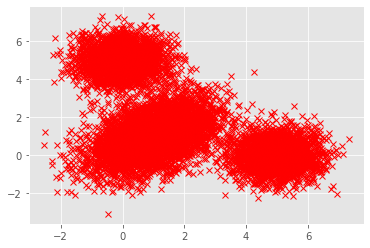

In [13]:
plot_points(data_)

In [14]:
mix = EM(data=data_, init_means= mus, init_covariances=covs,init_weights=wgts)

Iteration 0
Iteration 3
Iteration 6
Iteration 9
Iteration 12
Iteration 14


In [15]:
em_res_table = PrettyTable(["Weights", "Means", "Covariances"]) 
em_res_table.add_row([mix["weights"], mix["means"], mix["covariances"]]) 
print(em_res_table)

+---------------------------------+-------------------------------------------------------------------------------------------------------+-----------------------------------------------------------------------+
|             Weights             |                                                 Means                                                 |                              Covariances                              |
+---------------------------------+-------------------------------------------------------------------------------------------------------+-----------------------------------------------------------------------+
| [0.2451494 0.2548376 0.500013 ] | [array([4.96937323, 0.00908609]), array([-0.01338141,  5.00653385]), array([0.98491216, 1.00531466])] |                  [array([[ 0.52681466, -0.00685775],                  |
|                                 |                                                                                                       |        [-0.0

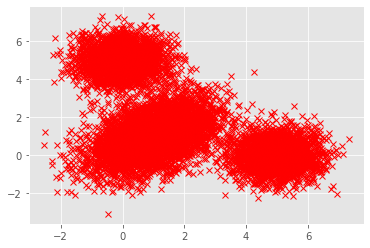

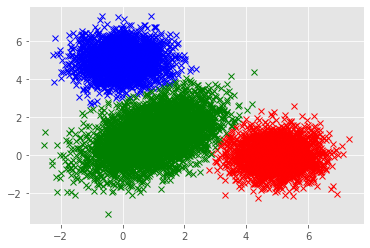

In [16]:
gaussians = dict()
for index,point in enumerate(mix["responsibilities"]):
  if gaussians.get(point.argmax()) is not None:
    gaussians[point.argmax()] = np.append(gaussians.get(point.argmax()),index)
  else:
    gaussians[point.argmax()] = np.array([index])

d0 = [data_[idx] for idx in gaussians.get(0)]
d1 = [data_[idx] for idx in gaussians.get(1)]
d2 = [data_[idx] for idx in gaussians.get(2)]

plot_points(data_)
plot_mixture(data=[d0,d1,d2])

\begin{equation}
log.likelihood                                            
\end{equation}




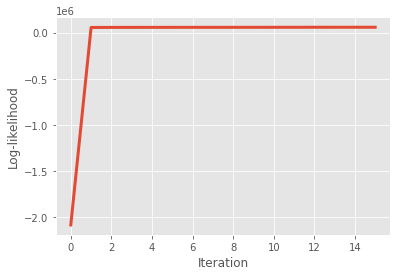

In [17]:
plt.close()
plt.plot(range(len(mix['loglikelihood'])), mix['loglikelihood'], linewidth=3)
plt.xlabel('Iteration')
plt.ylabel('Log-likelihood')
plt.show()

In [ ]:
from google.colab import files
files.upload()

In [19]:
from PIL import Image

COLORS = [
    (255, 0, 0),   # red
    (0, 255, 0),  # green
    (0, 0, 255),   # blue
    (255, 255, 0), # yellow
    (255, 0, 255), # magenta
]

def load_image(infilename) :
    img = Image.open( infilename )
    img.load()
    data = np.asarray( img, dtype="int32" )
    return data

In [34]:
def load_img(filename):
  image_path = '{}.jpg'.format(filename)
  image = load_image(image_path)
  image_height, image_width, image_channels = image.shape
  image_pixels = np.reshape(image, (-1, image_channels))
  _mean = np.mean(image_pixels,axis=0,keepdims=True)
  _std = np.std(image_pixels,axis=0,keepdims=True)
  image_pixels = (image_pixels - _mean) / _std # Normalization
  return {'image_pixels':image_pixels, 'image_height':image_height, 'image_width':image_width}

In [35]:
load_img = load_img('fox')
pixels = load_img['image_pixels']
image_height = load_img['image_height']
image_width = load_img['image_width']

In [22]:
from sklearn.cluster import KMeans

In [23]:
n_comp = 3

In [24]:
kmeans = KMeans(n_clusters=n_comp)
labels = kmeans.fit_predict(pixels)
initial_mus = kmeans.cluster_centers_
initial_weights, initial_covs = [], []
for i in range(n_comp):
    datas = np.array([pixels[j, :] for j in range(len(labels)) if labels[j] == i]).T
    initial_covs.append(np.cov(datas))
    initial_weights.append(datas.shape[1] / float(len(labels)))

In [26]:
mix = EM(data=pixels, init_means= initial_mus, init_covariances=initial_covs,init_weights=initial_weights)

Iteration 0
Iteration 3
Iteration 6
Iteration 9
Iteration 12
Iteration 14


In [36]:
print(image_height,image_width)

534 800


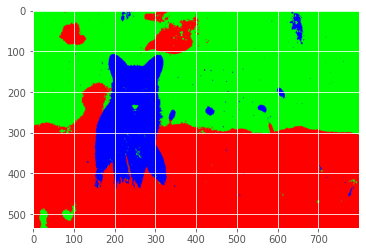

In [33]:
map_beliefs = np.reshape(mix['responsibilities'], (image_height, image_width, n_comp))
segmented_map = np.zeros((image_height, image_width, 3))
for i in range(image_height):
    for j in range(image_width):
        hard_belief = np.argmax(map_beliefs[i, j, :])
        segmented_map[i,j,:] = np.asarray(COLORS[hard_belief]) / 255.0
plt.imshow(segmented_map)
plt.show()